In [1]:
%load_ext autoreload
import ddsp
from pathlib import Path
import os
import torch
import yaml
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']= (15, 3)

os.getcwd()
os.chdir('/home/hugo/lab/ddsp_pytorch/')

In [2]:
def decoder_interpolator(config1, config2, data_config, pm=1, ladd=0):

    model = ddsp.export.get_ddsp_interpolator(config1, config2)

    data_config['train']['batch'] = 6
    dm = ddsp.data.Datamodule(data_config)
    dm.setup()

    train_loader = dm.train_dataloader()
    val_loader = dm.val_dataloader()

    b = next(iter(val_loader))
    pitch = torch.cat([a for a in b['f0']], dim=0).unsqueeze(0)
    loudness = torch.cat([a for a in b['loudness']], dim=0).unsqueeze(0)
    loudness = loudness + ladd
    print(loudness)
    print(pitch)

    # build a linear ramp from 0 to 1 as alpha
    n_bins = pitch.shape[1]
    alpha =  1 - 1 / n_bins * torch.arange(n_bins)
    alpha = alpha.unsqueeze(0).unsqueeze(-1)

    model.eval()
    with torch.no_grad():
        output = model(pitch*pm, loudness, 1)
        output['alpha'] = alpha
    return model, output

In [3]:
def plot_interpolator(model, output):
    plt.clf()
    ax = plt.subplot(141)
    model.ddsp1.harmonic_synth.plot(ax, output['harmonic_ctrls'])
    ax = plt.subplot(142)
    model.ddsp1.noise_synth.plot(ax, output['noise_ctrls'])
    ax = plt.subplot(143)
    plt.plot(output['f0'].view(-1))
    ax.set_title('f0')
    ax = plt.subplot(144)
    plt.plot(output['loudness'].view(-1))
    ax.set_title('loudness')
    plt.tight_layout()
    return plt.gcf()

In [4]:
old_configs = {
    'violin': ddsp.export.load_config('./runs/violin-omg/config.yaml'), 
    'flute': ddsp.export.load_config('./runs/flute-omg/config.yaml'), 
    'reed': ddsp.export.load_config('./runs/reed_acoustic_011/config.yaml'),
    'string': ddsp.export.load_config('./runs/string_acoustic_080/config.yaml'),
    'bass_synth': ddsp.export.load_config('./runs/bass_synthetic_012/config.yaml'),
    'flute_synth': ddsp.export.load_config('./runs/flute_synthetic_002/config.yaml'),
    'rainbow': ddsp.export.load_config('./configs/rainbow.yaml')
}

configs = {
    p.parent.name: ddsp.export.load_config(p)
        for p in Path('./runs').glob('**/config.yaml')
}
list(configs.keys())
configs['rainbow'] = old_configs['rainbow']

tensor([[[-10.7240],
         [-10.7759],
         [-13.2939],
         ...,
         [-19.7440],
         [-19.7440],
         [-19.7440]]])
tensor([[[142.5686],
         [142.2454],
         [141.0590],
         ...,
         [  0.0000],
         [  0.0000],
         [  0.0000]]])


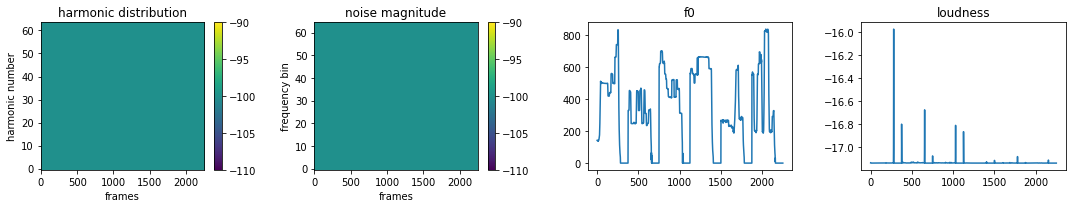

In [5]:
model, output = decoder_interpolator( configs['clarinet-dcdr'], configs['violin-dcdr'], configs['clarinet-dcdr'], 
                                     pm=1, ladd=1)
audio = output['signal']

plot_interpolator(model, output)
import IPython.display as ipd
ipd.Audio(audio.view(-1), rate=48000) # load a NumPy array

/home/hugo/venv/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/hugo/venv/lib/python3.7/site-packages/IPython/lib/display.py:157: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


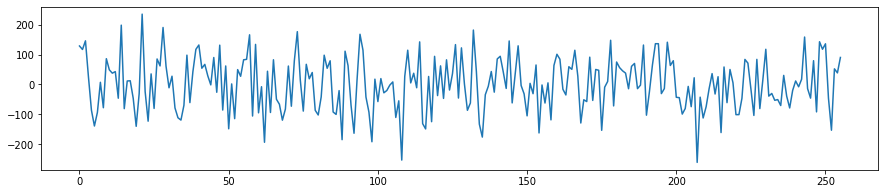

In [145]:
import numpy as np

SR = 16000
n_harmonics = 1

f0 = 220*1
t = np.arange(SR) / SR
sig = np.zeros(SR)
for n in range(1, n_harmonics+1):
    sig += 1 / n * np.sin(2 * np.pi * n * f0 * t)

plt.plot(sig[0:256])
ipd.Audio(sig, rate=SR)

$$
\sum_{n=1}^{N}\frac{1}{n} sin(2\pi \cdot nf_0)
$$